In [1]:
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install torch torchvision
!pip install pycocotools
!pip install requests
!pip install notebook

  Using cached numpy-2.1.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp313-cp313-win_amd64.whl (12.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp313-cp313-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------ --------------------------- 2.4/7.8 MB 11.8 MB/s eta 0:00:01
   ------------------------ --------------- 4.7/7.8 MB 11.8 MB/s eta 0:00:01
   ------------------------------------ --- 7.1/7.8 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 11.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.2 MB/s eta 0:00:00
Using cached k

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


  Using cached pycocotools-2.0.8.tar.gz (24 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0.8-cp313-cp313-win_amd64.whl size=82516 sha256=210b046bb450341dade72e1f36032ee6833f897ee70cfeebcb14b07d2024e75f
  Stored in directory: c:\users\rmcgove3\appdata\local\pip\cache\wheels\a3\c8\17\9a271afbebc0abbc30d6d0da53284602f92208c8437b11cf32
Successfully built pycocotools


In [2]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image, ImageDraw
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models import resnet50, ResNet50_Weights

from pycocotools.coco import COCO
import requests

In [3]:
# Enable CuDNN benchmarking
torch.backends.cudnn.benchmark = True

# current path
current_path = Path.cwd()

print("current_path:", current_path)

# Paths to COCO dataset annotations and images
TRAIN_ANNOTATION_PATH = r"D:\Ryan\datasets\Pose\annotations_trainval2017\annotations\person_keypoints_train2017.json"
VAL_ANNOTATION_PATH = r"D:\Ryan\datasets\Pose\annotations_trainval2017\annotations\person_keypoints_val2017.json"
TRAIN_IMAGE_PATH = r"D:\Ryan\datasets\Pose\train2017\train2017"
VAL_IMAGE_PATH = r"D:\Ryan\datasets\Pose\val2017\val2017"

# Number of keypoints in COCO dataset
NUM_KEYPOINTS = 17

# Input and output image sizes
INPUT_SIZE = (192, 256)   # Width, Height
OUTPUT_SIZE = (64, 48)    # Height, Width (for heatmaps)

# Random seed for reproducibility
SEED = 42

current_path: C:\Users\rmcgove3\cv-project-pose-estimation-main\cv-project-pose-estimation-main


In [4]:
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
class PersonKeypointsDataset(Dataset):
    def __init__(self, annotation_file, image_path, min_keypoints=9, max_samples=None, transform=None, target_transform=None, seed=SEED):
        """
        Custom Dataset for COCO Person Keypoints
        """
        self.coco = COCO(annotation_file)
        self.image_path = str(image_path)
        self.transform = transform
        self.target_transform = target_transform
        self.person_ids = self.coco.getCatIds(catNms=['person'])
        self.img_ids = self.coco.getImgIds(catIds=self.person_ids)

        # Set seeds for reproducibility
        set_seed(seed)
        
        # Build list of (image_id, annotation) tuples
        self.samples = []
        for img_id in self.img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.person_ids, iscrowd=False)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                # Include only samples with enough keypoints
                if 'keypoints' in ann and ann['num_keypoints'] >= min_keypoints:
                    self.samples.append((img_id, ann))

        # Randomly sample if we have more samples than max_samples
        if max_samples and max_samples < len(self.samples):
            self.samples = random.sample(self.samples, max_samples)
            print(f"Randomly sampled {len(self.samples)} images from {len(self.samples)} total images")
                        
    def __len__(self):
        """
        Returns the number of samples in the dataset
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Fetches the image and keypoints for the given index.
        """
        img_id, ann = self.samples[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_path, img_info['file_name'])
        if not os.path.exists(img_path):
            raise RuntimeError(f"Image file not found: {img_path}")
        img = Image.open(img_path).convert("RGB")
        
        # Get bounding box
        bbox = ann['bbox']  # [x, y, w, h]
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        
        # Crop image to bounding box
        img = img.crop((x1, y1, x2, y2))
        
        orig_w, orig_h = img.size
        
        # Adjust keypoints
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)
        keypoints[:, 0] -= x1
        keypoints[:, 1] -= y1
        
        # Resize image and keypoints
        new_size = INPUT_SIZE  # (width, height)
        img = img.resize(new_size, resample=Image.BILINEAR)
        
        scale_x = new_size[0] / orig_w
        scale_y = new_size[1] / orig_h
        keypoints[:, 0] = (keypoints[:, 0] * scale_x)
        keypoints[:, 1] = (keypoints[:, 1] * scale_y)
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)
        
        # Generate heatmaps
        if self.target_transform:
            target = self.target_transform(keypoints)
        else:
            target = torch.tensor(keypoints, dtype=torch.float32)
        
        return img, target, keypoints

In [6]:
class HeatmapGenerator:
    """
    Generates heatmaps for each keypoint.
    Uses Gaussian distributions.
    """
    def __init__(self, output_size, num_keypoints, sigma=2):
        self.output_size = output_size  # (height, width)
        self.num_keypoints = num_keypoints
        self.sigma = sigma
        
    def __call__(self, keypoints):
        heatmaps = np.zeros((self.num_keypoints, self.output_size[0], self.output_size[1]), dtype=np.float32)
        tmp_size = self.sigma * 3
        
        for i in range(self.num_keypoints):
            kp = keypoints[i]
            x, y, v = kp
            if v > 0:
                x = x * self.output_size[1] / INPUT_SIZE[0]
                y = y * self.output_size[0] / INPUT_SIZE[1]
                
                ul = [int(x - tmp_size), int(y - tmp_size)]
                br = [int(x + tmp_size + 1), int(y + tmp_size + 1)]
                
                if ul[0] >= self.output_size[1] or ul[1] >= self.output_size[0] or br[0] < 0 or br[1] < 0:
                    continue
                
                size = 2 * tmp_size + 1
                x_coords = np.arange(0, size, 1, np.float32)
                y_coords = x_coords[:, np.newaxis]
                x0 = y0 = size // 2
                g = np.exp(- ((x_coords - x0) ** 2 + (y_coords - y0) ** 2) / (2 * self.sigma ** 2))
                
                g_x = max(0, -ul[0]), min(br[0], self.output_size[1]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], self.output_size[0]) - ul[1]
                
                img_x = max(0, ul[0]), min(br[0], self.output_size[1])
                img_y = max(0, ul[1]), min(br[1], self.output_size[0])
                
                heatmaps[i][img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
                
        return torch.tensor(heatmaps, dtype=torch.float32)

In [7]:
def visualize_sample(dataset, idx):
    """
    Visualizes the image with keypoints and connections.
    Prints the number of keypoints and edges drawn for the given image.
    """
    img, _, keypoints = dataset[idx]
    img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C

    plt.figure(figsize=(5, 7))
    plt.imshow(img)
    
    # Extract keypoint data
    x = keypoints[:, 0]
    y = keypoints[:, 1]
    v = keypoints[:, 2]

    # COCO keypoint connections
    skeleton = [
        [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
        [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
        [1, 3], [2, 4], [3, 5], [4, 6]
    ]
    
    # Count visible keypoints
    visible_keypoints = np.sum(v > 0)
    print(f"Image {idx}: Number of visible keypoints: {visible_keypoints}")

    # Draw limbs and count edges
    edge_count = 0
    for connection in skeleton:
        p1, p2 = connection
        if v[p1] > 0 and v[p2] > 0:  # Only connect visible keypoints
            plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)
            edge_count += 1

    print(f"Image {idx}: Number of edges drawn: {edge_count}")

    # Draw keypoints
    for i in range(len(x)):
        if v[i] > 0:
            plt.plot(x[i], y[i], 'bo', markersize=5)

    plt.axis('off')
    plt.show()

In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize dataset
dataset_for_visual = PersonKeypointsDataset(
    annotation_file=TRAIN_ANNOTATION_PATH,
    image_path=TRAIN_IMAGE_PATH,
    min_keypoints=9,
    max_samples=None,
    transform=transform,
    target_transform=None  # no need to use heatmaps for visualization
)

loading annotations into memory...
Done (t=6.61s)
creating index...
index created!


108444
Image 100: Number of visible keypoints: 12
Image 100: Number of edges drawn: 13


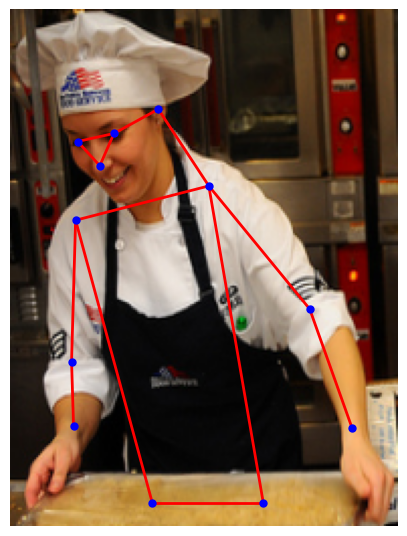

Image 101: Number of visible keypoints: 13
Image 101: Number of edges drawn: 15


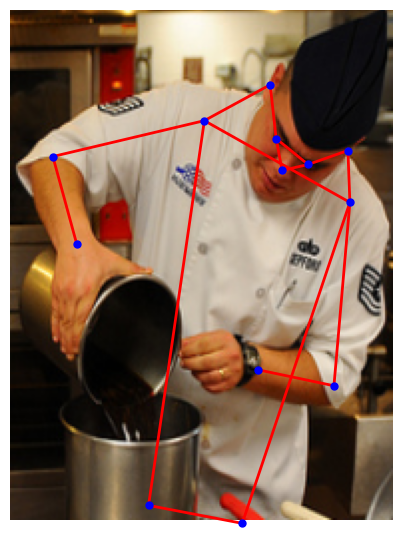

Image 102: Number of visible keypoints: 17
Image 102: Number of edges drawn: 19


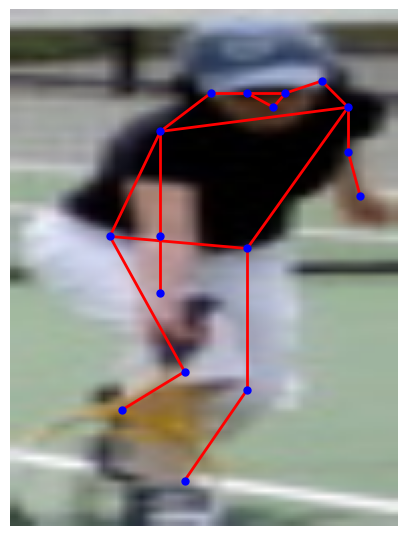

Image 103: Number of visible keypoints: 16
Image 103: Number of edges drawn: 17


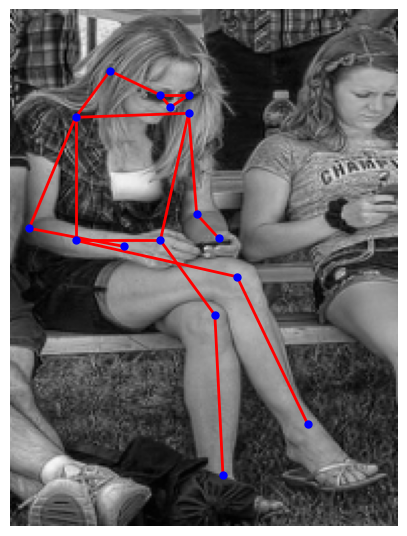

Image 104: Number of visible keypoints: 9
Image 104: Number of edges drawn: 9


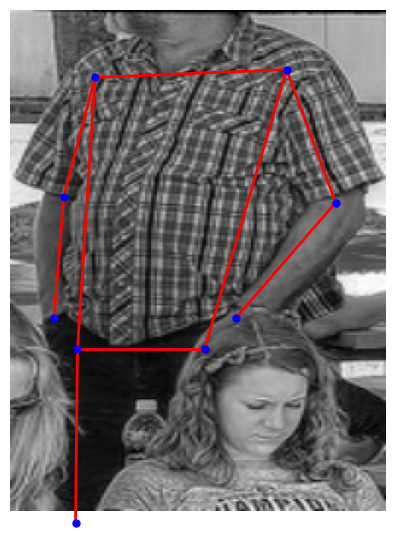

Image 105: Number of visible keypoints: 16
Image 105: Number of edges drawn: 17


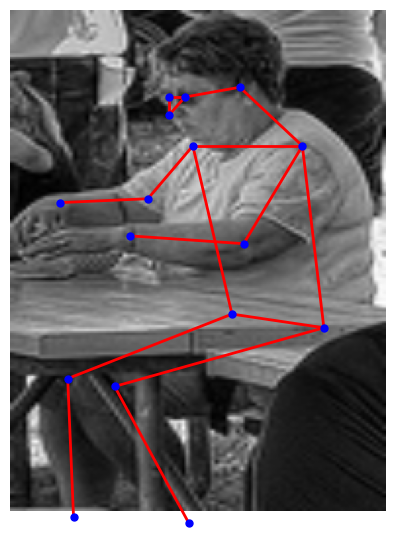

Image 106: Number of visible keypoints: 16
Image 106: Number of edges drawn: 17


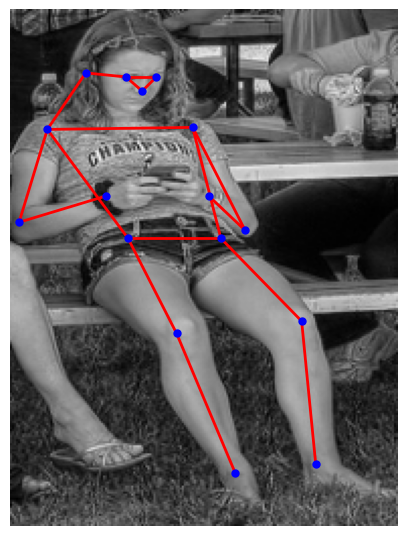

Image 107: Number of visible keypoints: 16
Image 107: Number of edges drawn: 17


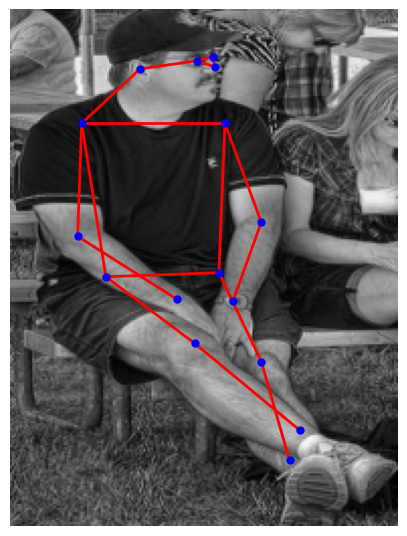

Image 108: Number of visible keypoints: 13
Image 108: Number of edges drawn: 14


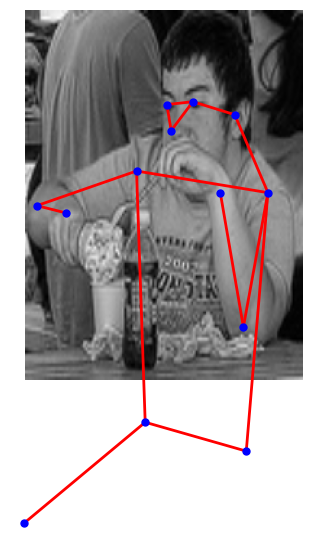

Image 109: Number of visible keypoints: 10
Image 109: Number of edges drawn: 9


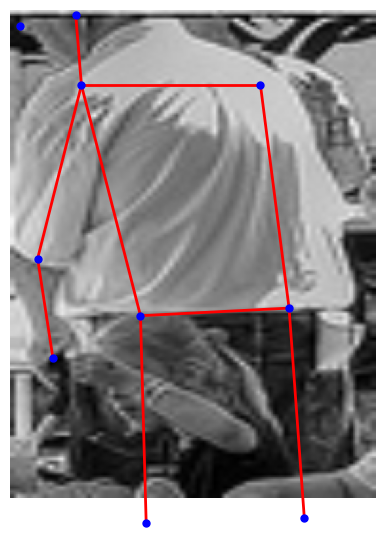

In [9]:
print(len(dataset_for_visual))

# Visualize a few samples
for idx in range(100, 110):
    visualize_sample(dataset_for_visual, idx)

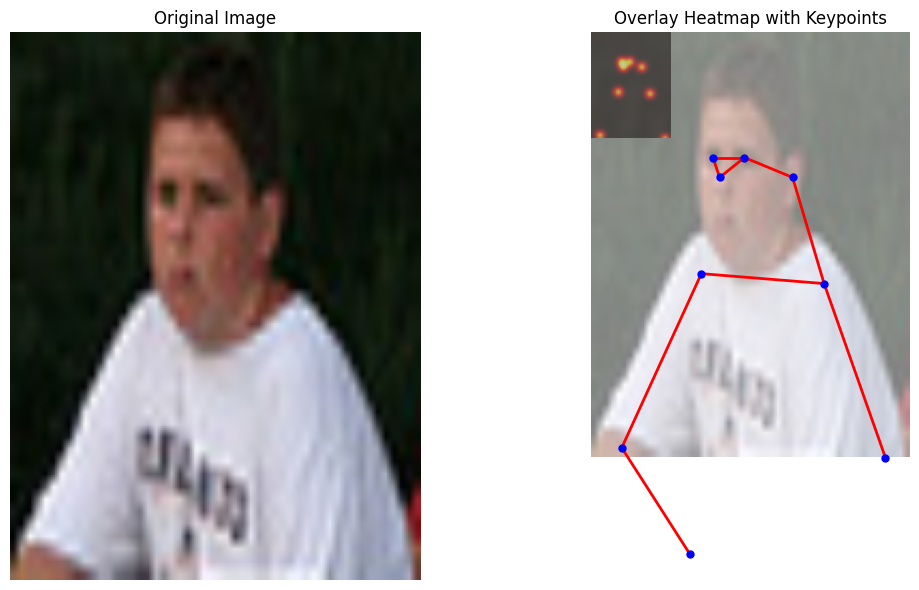

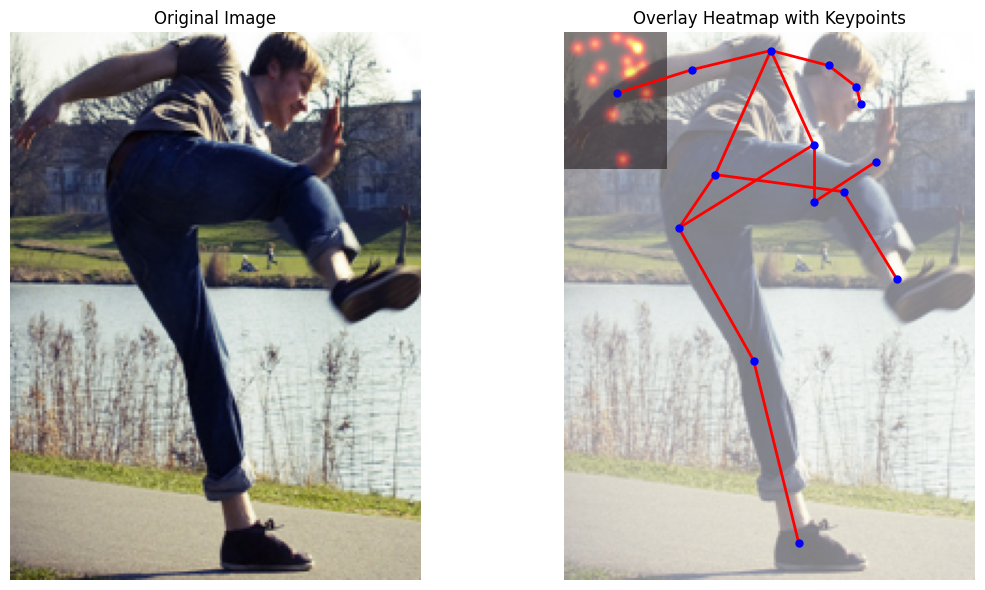

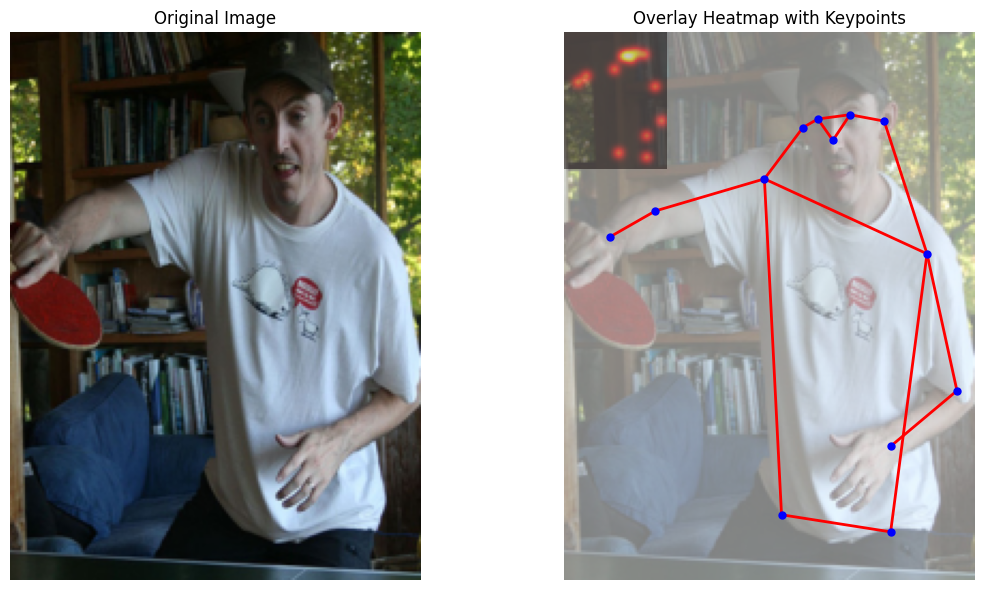

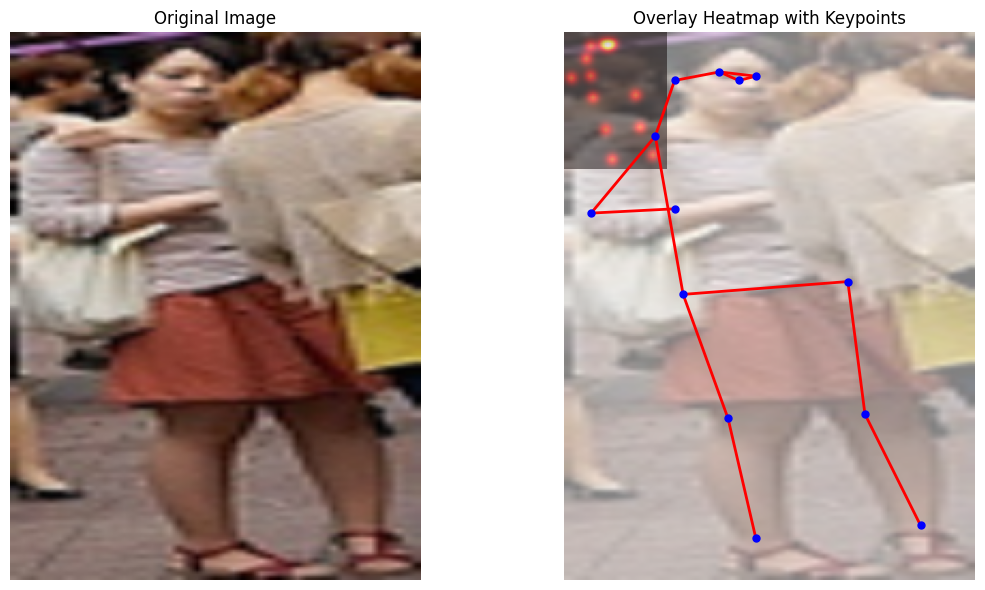

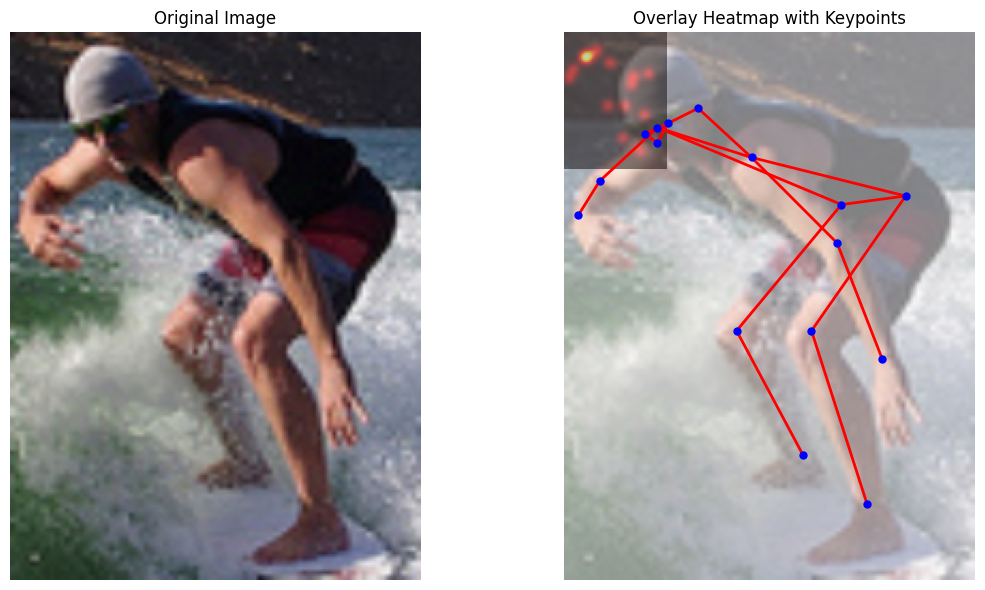

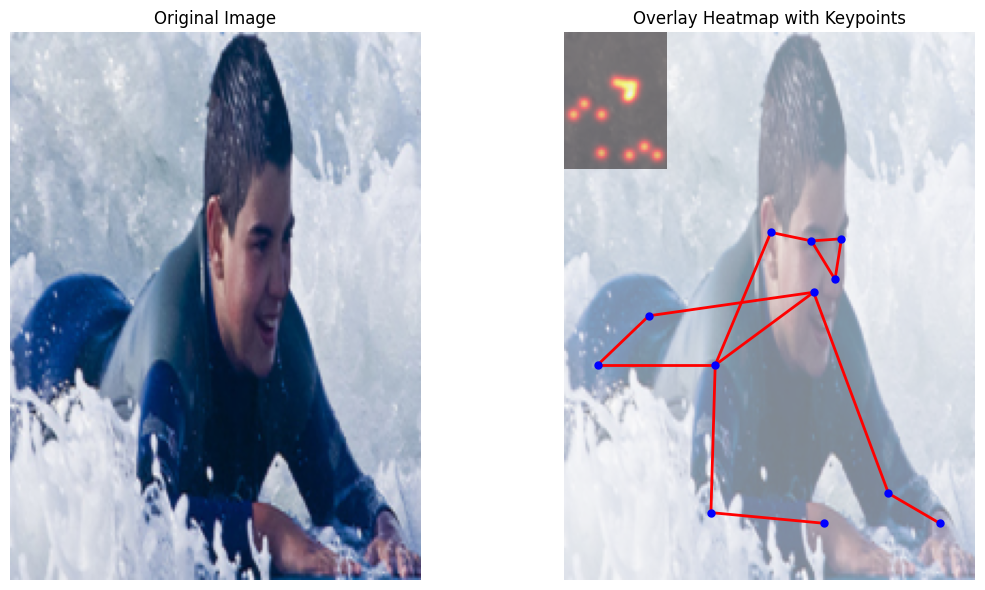

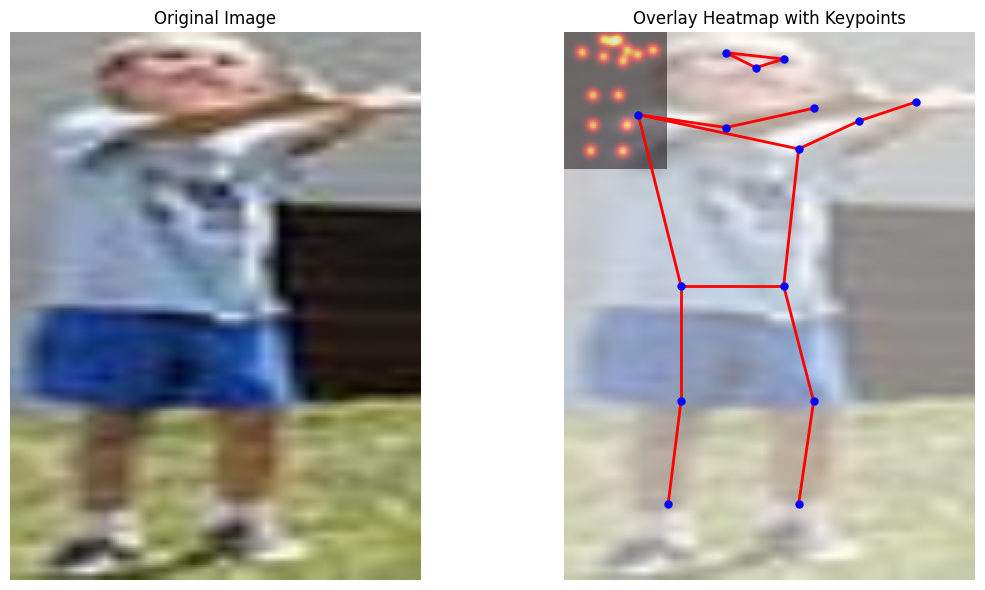

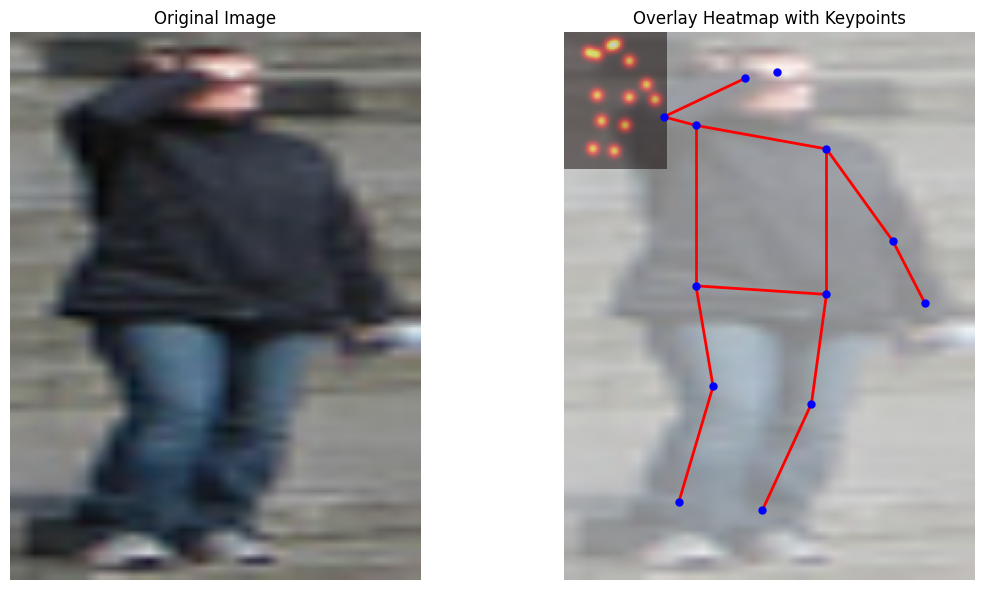

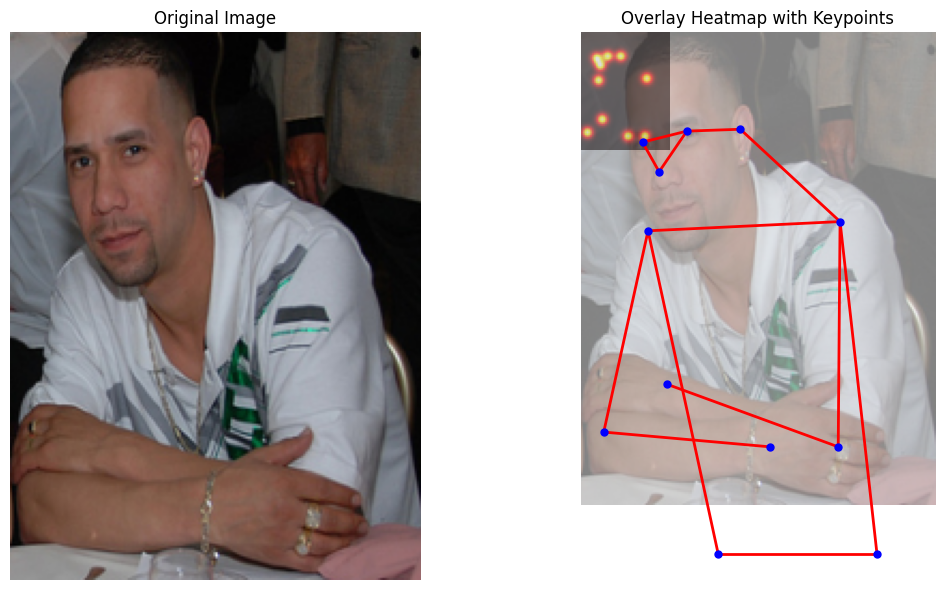

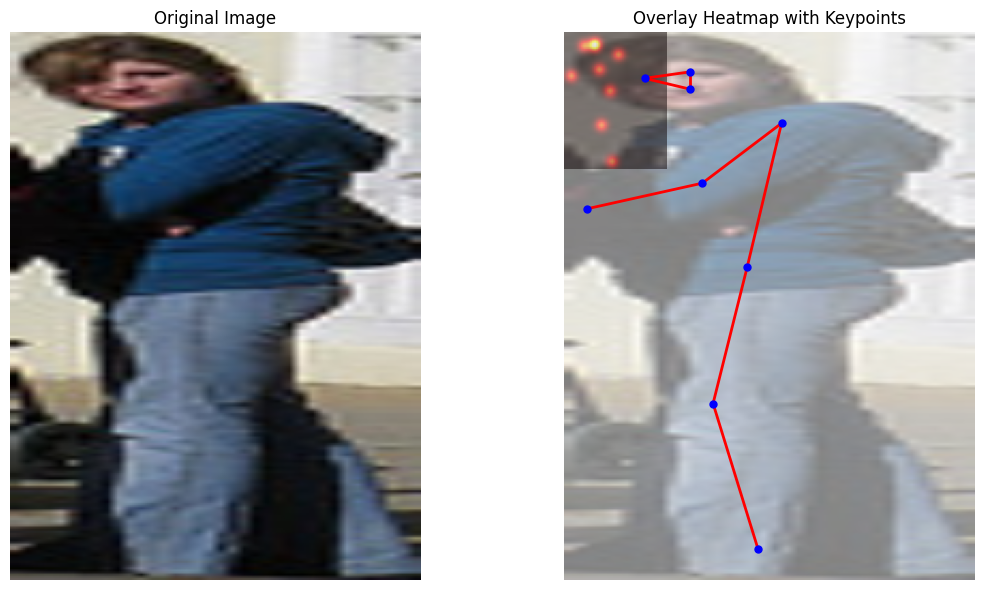

In [10]:
#### Visualize Heatmaps and Keypoints ####

def visualize_with_keypoints_and_heatmaps(dataset, idx, heatmap_generator):
    """
    Visualize the original image and overlay heatmap with keypoints and skeleton connections.
    """
    img, _, keypoints = dataset[idx]
    img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C for visualization

    # Generate heatmaps
    heatmaps = heatmap_generator(keypoints)
    heatmaps_np = heatmaps.numpy()
    combined_heatmap = np.sum(heatmaps_np, axis=0)

    # Extract keypoint data
    x = keypoints[:, 0]
    y = keypoints[:, 1]
    v = keypoints[:, 2]

    # COCO keypoint connections
    skeleton = [
        [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
        [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
        [1, 3], [2, 4], [3, 5], [4, 6]
    ]

    # Plot original image on the left
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Plot overlay heatmap with keypoints and skeleton on the right
    plt.subplot(1, 2, 2)
    plt.imshow(img, alpha=0.5)
    plt.imshow(combined_heatmap, cmap='hot', alpha=0.5)
    
    # Draw limbs and count edges
    edge_count = 0
    for connection in skeleton:
        p1, p2 = connection
        if v[p1] > 0 and v[p2] > 0:  # Only connect visible keypoints
            plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)
            edge_count += 1

    # Draw keypoints
    for i in range(len(x)):
        if v[i] > 0:
            plt.plot(x[i], y[i], 'bo', markersize=5)

    plt.title("Overlay Heatmap with Keypoints")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Create an instance of HeatmapGenerator
heatmap_generator = HeatmapGenerator(output_size=OUTPUT_SIZE, num_keypoints=NUM_KEYPOINTS)

# Visualize heatmaps and keypoints for random samples
for _ in range(10):
    random_idx = random.randint(0, len(dataset_for_visual) - 1)
    visualize_with_keypoints_and_heatmaps(dataset_for_visual, random_idx, heatmap_generator)


In [11]:
class AlphaPoseModel(nn.Module):
    def __init__(self, num_keypoints):
        super(AlphaPoseModel, self).__init__()
        # Load pretrained ResNet50
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Remove the last fc layer and avgpool
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        # Deconvolution layers
        self.deconv_layers = self._make_deconv_layer(3, [256, 256, 256], [4, 4, 4])
        # Final layer to predict heatmaps
        self.final_layer = nn.Conv2d(in_channels=256, out_channels=num_keypoints, kernel_size=1, stride=1, padding=0)
        
    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        layers = []
        for i in range(num_layers):
            kernel = num_kernels[i]
            planes = num_filters[i]
            layers.append(nn.ConvTranspose2d(
                in_channels=2048 if i==0 else num_filters[i-1],
                out_channels=planes,
                kernel_size=kernel,
                stride=2,
                padding=1,
                output_padding=0,
                bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.deconv_layers(x)
        x = self.final_layer(x)
        return x

In [12]:
# Re-initialize dataset with target_transform (heatmaps)
target_transform = HeatmapGenerator(output_size=OUTPUT_SIZE, num_keypoints=NUM_KEYPOINTS)

dataset = PersonKeypointsDataset(
    annotation_file=TRAIN_ANNOTATION_PATH,
    image_path=TRAIN_IMAGE_PATH,
    min_keypoints=9,
    max_samples=None,
    transform=transform,
    target_transform=target_transform
)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Initialize test dataset (using COCO validation data)
test_dataset = PersonKeypointsDataset(
    annotation_file=VAL_ANNOTATION_PATH,
    image_path=VAL_IMAGE_PATH,
    min_keypoints=9,
    max_samples=None,
    transform=transform,
    target_transform=target_transform
)
print(f"Test samples: {len(test_dataset)}")

loading annotations into memory...
Done (t=6.52s)
creating index...
index created!
Training samples: 86755
Validation samples: 21689
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Test samples: 4491


In [23]:
# Adjust batch size based on GPU memory
BATCH_SIZE = 16  # Increase batch size to utilize GPU memory

# Initialize DataLoaders with more workers
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = AlphaPoseModel(num_keypoints=NUM_KEYPOINTS).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [25]:
import time
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler('cuda' if device.type == 'cuda' else None)

train_losses = []
val_losses = []
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    start_time = time.time()

    # Training loop
    for images, targets, _ in train_loader:
        images = images.to(device)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, targets, _ in val_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # Mixed precision validation: forward pass
            if device.type == 'cuda':
                with autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(images)
                loss = criterion(outputs, targets)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Time: {elapsed_time:.2f}s")

    torch.save(model.state_dict(), f'AlphaPose_model_epoch_{epoch}_loss_{avg_val_loss}.pth')

Epoch [1/100], Train Loss: 0.0024, Validation Loss: 0.0016, Time: 1751.01s
Epoch [2/100], Train Loss: 0.0015, Validation Loss: 0.0014, Time: 1582.13s
Epoch [3/100], Train Loss: 0.0013, Validation Loss: 0.0014, Time: 1584.83s
Epoch [4/100], Train Loss: 0.0012, Validation Loss: 0.0013, Time: 1429.26s
Epoch [5/100], Train Loss: 0.0011, Validation Loss: 0.0013, Time: 1621.65s
Epoch [6/100], Train Loss: 0.0010, Validation Loss: 0.0013, Time: 1631.10s
Epoch [7/100], Train Loss: 0.0009, Validation Loss: 0.0014, Time: 1620.35s
Epoch [8/100], Train Loss: 0.0008, Validation Loss: 0.0014, Time: 1632.77s
Epoch [9/100], Train Loss: 0.0008, Validation Loss: 0.0014, Time: 1636.90s
Epoch [10/100], Train Loss: 0.0007, Validation Loss: 0.0014, Time: 1636.35s
Epoch [11/100], Train Loss: 0.0007, Validation Loss: 0.0014, Time: 1391.91s
Epoch [12/100], Train Loss: 0.0006, Validation Loss: 0.0014, Time: 1389.34s
Epoch [13/100], Train Loss: 0.0006, Validation Loss: 0.0015, Time: 1591.65s
Epoch [14/100], Train

KeyboardInterrupt: 

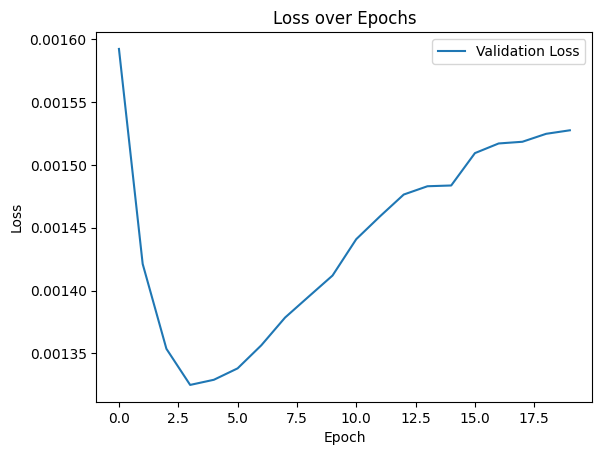

In [21]:
plt.figure()
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

C:\Users\rmcgove3\AppData\Local\Temp\ipykernel_18892\1568257120.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)


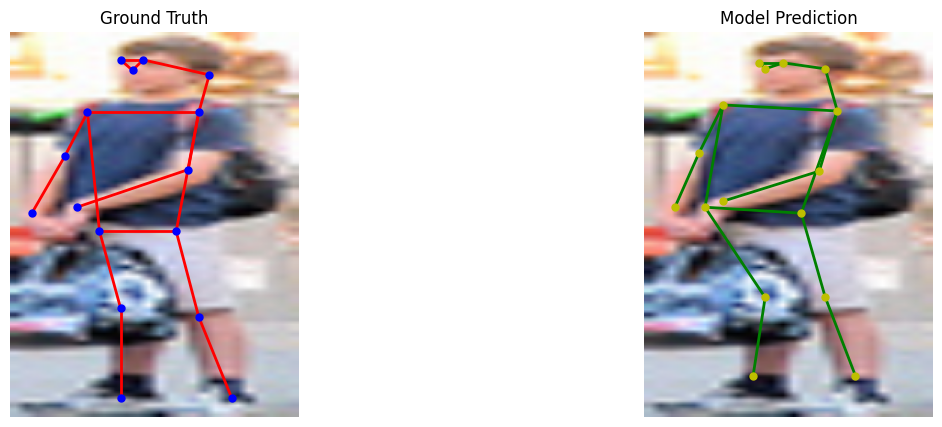

RuntimeError: Image file not found: D:\Ryan\datasets\Pose\val2017\val2017\000000393469.jpg

In [22]:
def visualize_results(model, dataset, idx):
    model.eval()
    with torch.no_grad():
        img, _, keypoints = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        outputs = model(img_tensor)
        output_heatmaps = outputs.squeeze(0).cpu()
        
        # Get predicted keypoints from heatmaps
        pred_keypoints = []
        for i in range(NUM_KEYPOINTS):
            heatmap = output_heatmaps[i]
            y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)
            confidence = heatmap.max()
            pred_x = (x / OUTPUT_SIZE[1]) * INPUT_SIZE[0]
            pred_y = (y / OUTPUT_SIZE[0]) * INPUT_SIZE[1]
            pred_keypoints.append((pred_x, pred_y, confidence))
        pred_keypoints = np.array(pred_keypoints)
        
        # Visualize Ground Truth
        img_np = img.permute(1, 2, 0).numpy()
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        x = keypoints[:, 0]
        y = keypoints[:, 1]
        v = keypoints[:, 2]

        # Draw ground truth skeleton
        for connection in skeleton:
            p1, p2 = connection
            if v[p1] > 0 and v[p2] > 0:
                plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)
        for i in range(len(x)):
            if v[i] > 0:
                plt.plot(x[i], y[i], 'bo', markersize=5)
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Visualize Prediction
        plt.subplot(1, 2, 2)
        plt.imshow(img_np)
        x = pred_keypoints[:, 0]
        y = pred_keypoints[:, 1]
        c = pred_keypoints[:, 2]

        # Draw predicted skeleton
        for connection in skeleton:
            p1, p2 = connection
            if c[p1] > 0.1 and c[p2] > 0.1:  # Threshold confidence
                plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'g-', linewidth=2)
        for i in range(len(x)):
            if c[i] > 0.1:
                plt.plot(x[i], y[i], 'yo', markersize=5)
        plt.title('Model Prediction')
        plt.axis('off')
        
        plt.show()

# Visualize results on test data
skeleton = [
    [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
    [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
    [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
    [1, 3], [2, 4], [3, 5], [4, 6]
]
skeleton = [[p1, p2] for p1, p2 in skeleton]

# Visualize model predictions on test dataset
for i in range(100, 150):
    visualize_results(model, test_dataset, i)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'AlphaPose_model.pth')